## Imports

In [45]:
import joblib
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from warnings import simplefilter, filterwarnings

filterwarnings("ignore", category=FutureWarning)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Parameters

In [46]:
patients = ['001', '002', '004', '006', '007', '008']
features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']

verbose = 0
train_size = 0.95

feature_params = {
    'simple_sugars': [0.5, 0.5],          # [insulin_sensitivity_param, peak_time]
    'complex_sugars': [0.3, 0.5],
    'proteins': [0.2, 3.5],
    'fats': [0.05, 3.5], 
    'dietary_fibers': [0.03, 3.5],
    'fast_insulin': [1.0, 0.5], 
    'slow_insulin': [0.5, 1.0]
}

lgb_params = {
    'max_depth': 3,
    'reg_lambda': 1,
    'objective': 'regression',
    'random_state': 42,
    'n_estimators': 500,
    'deterministic': True,
    'verbosity': -1
}

model = lgb.LGBMRegressor(**lgb_params)  
callbacks = [lgb.early_stopping(stopping_rounds=20, verbose=False)]  

## Functions

In [64]:
def get_data(patient, food_data_source, prediction_horizon):
    glucose_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/glucose.csv")
    insulin_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv")
    food_data = pd.read_csv(f"food_data/{food_data_source}/{patient}.csv")

    glucose_data["datetime"] = pd.to_datetime(glucose_data["date"] + ' ' + glucose_data["time"])
    glucose_data.drop(['type', 'comments', 'date', 'time'], axis=1, inplace=True)
    glucose_data['glucose'] *= 18.0182  # Convert to mg/dL

    insulin_data["datetime"] = pd.to_datetime(insulin_data["date"] + ' ' + insulin_data["time"])
    insulin_data.drop(['comment', 'date', 'time'], axis=1, inplace=True)

    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data = food_data[['datetime', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers', 'weight']]

    combined_data = pd.concat([food_data, insulin_data]).sort_values('datetime').reset_index(drop=True)
    combined_data.fillna(0, inplace=True)

    glucose_data['hour'] = glucose_data['datetime'].dt.hour

    # Existing features
    glucose_data['glucose_next'] = glucose_data['glucose'] - glucose_data['glucose'].shift(-prediction_horizon)
    glucose_data['glucose_change'] = glucose_data['glucose'] - glucose_data['glucose'].shift(1)
    glucose_data['glucose_change_ph'] = glucose_data['glucose'] - glucose_data['glucose'].shift(prediction_horizon)
    glucose_data['glucose_change_ema_ph'] = glucose_data['glucose_change'].ewm(span=prediction_horizon, adjust=False).mean()
    delta = glucose_data['glucose'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=prediction_horizon).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=prediction_horizon).mean()
    glucose_data['glucose_rsi'] = 100 - (100 / (1 + gain / loss))

    def get_trend_intercept(window):
        x = np.arange(len(window))
        coeffs = np.polyfit(x, window, deg=1)
        return coeffs[1]  # Return intercept

    glucose_data['glucose_change_trend_intercept'] = glucose_data['glucose_change'].rolling(
        window=6, min_periods=2
    ).apply(get_trend_intercept)

    # Drop rows with NaN values resulting from shifting and rolling calculations
    glucose_data.dropna(subset=['glucose_next'], inplace=True)

    return glucose_data, combined_data

def add_features_and_create_patient_data(params, features, preprocessed_data, prediction_horizon):
    patients_glucose_data = []
    
    for patient in patients:
        glucose_data, combined_data = preprocessed_data[patient]
        glucose_times = glucose_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
        combined_times = combined_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
        for feature in features:
            metabolism_rate, peak_time = params[feature]
            time_diff_hours = ((glucose_times[:, None] - combined_times[None, :]) / 3600)
            weights = np.zeros_like(time_diff_hours)
            increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
            weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
            plateau_duration = 0.25 
            plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
            weights[plateau_mask] = 1
            decrease_mask = time_diff_hours >= peak_time + plateau_duration
            weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
            weights = np.clip(weights, 0, None)
            glucose_data[feature] = np.dot(weights, combined_data.loc[:, feature].values)
            glucose_data[feature] = glucose_data[feature] - glucose_data[feature].shift(-prediction_horizon) + glucose_data['glucose_change']

        glucose_data['total_carbs'] = glucose_data['simple_sugars'] + glucose_data['complex_sugars']

        glucose_data['patient'] = patient

        patients_glucose_data.append(glucose_data)
    patients_glucose_data = pd.concat(patients_glucose_data)
    patients_glucose_data.dropna(inplace=True)
    return patients_glucose_data

## Results

In [65]:
df = pd.DataFrame(columns=['Approach', 'Prediction Horizon', 'Patient', 'RMSE'])
approaches = ['gpt4o', 'sonnet', 'llava']
prediction_horizons = [6,9,12]

for approach in approaches:
    for prediction_horizon in prediction_horizons:
        data = {patient: get_data(patient, approach, prediction_horizon) for patient in patients}

        # Loop over patients
        rmses = []
        processed_data = add_features_and_create_patient_data(feature_params, features, data, prediction_horizon)
        for patient in patients:
            all_test = processed_data[processed_data['patient'] == patient]
            other_patient_train = processed_data[processed_data['patient'] != patient]
            all_preds = []
            all_ground_truth = []
            
            grouped = all_test.groupby([all_test['datetime'].dt.day, 'hour'])
            current_idx = 0
            
            for (day, hour), test in grouped:
                day_mask = all_test['datetime'].dt.day == day
                hour_mask = all_test['hour'] == hour
                other_day_test = all_test[~day_mask]
                other_hour_test = all_test[day_mask & ~hour_mask]
                train = pd.concat([other_patient_train, other_day_test, other_hour_test])
                    
                weights = np.ones(len(train))
                weights[train['patient'] == patient] *= 5
                
                features_to_remove = ['glucose_next', 'datetime', 'patient']
                X, y = train.drop(features_to_remove, axis=1), train['glucose_next']
                X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(X, y, weights, train_size=train_size, random_state=42)
                X_test, y_test = test.drop(features_to_remove, axis=1), test['glucose_next']

                model.fit(X_train, y_train,
                        sample_weight=weights_train,
                        eval_set=[(X_val, y_val)],
                        eval_metric='rmse',
                        callbacks=callbacks)
                y_preds = model.predict(X_test)
                all_preds = np.concatenate((all_preds, y_preds))
                all_ground_truth = np.concatenate((all_ground_truth, y_test))
            
            # Store ground truth and predictions
            predictions_df = pd.DataFrame({
                'Patient': patient, 
                'Approach': approach, 
                'Prediction horizon': prediction_horizon, 
                'Datetime': all_test['datetime'], 
                'Initial_glucose': all_test['glucose'],
                'Ground_truth': all_ground_truth, 
                'Predictions': all_preds}
            )
            preds_dir = f"predictions/{approach}/{prediction_horizon}"
            os.makedirs(preds_dir, exist_ok=True)
            predictions_df.to_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv", index=False)
            
            rmse = np.sqrt(mean_squared_error(all_ground_truth, all_preds))
            rmses.append(rmse)

            # Store RMSE
            new_entry = pd.DataFrame({
                'Approach': [approach],
                'Prediction Horizon': [prediction_horizon],
                'Patient': [patient],
                'RMSE': [rmse]
            })
            df = pd.concat([df, new_entry], ignore_index=True)

            # Store models
            model_dir = f"models/{approach}/{prediction_horizon}"
            os.makedirs(model_dir, exist_ok=True)
            joblib.dump(model, f"{model_dir}/lightgbm_model_{patient}.joblib")
            data_dir = f"data/{approach}/{prediction_horizon}"
            os.makedirs(data_dir, exist_ok=True)
            processed_data.to_csv(f"{data_dir}/data.csv", index=False)
        print(f"RMSE: {np.mean(rmses)}, {approach}, {prediction_horizon}")
df.to_csv('results.csv', index=False)

RMSE: 19.643751672519986, gpt4o, 6
RMSE: 29.504575439266205, gpt4o, 9
RMSE: 37.00037655587533, gpt4o, 12
RMSE: 19.90123192704546, sonnet, 6
RMSE: 29.754134303666365, sonnet, 9
RMSE: 37.075309045073375, sonnet, 12
RMSE: 20.074799223031675, llava, 6
RMSE: 30.18021017841423, llava, 9
RMSE: 37.29046650977438, llava, 12


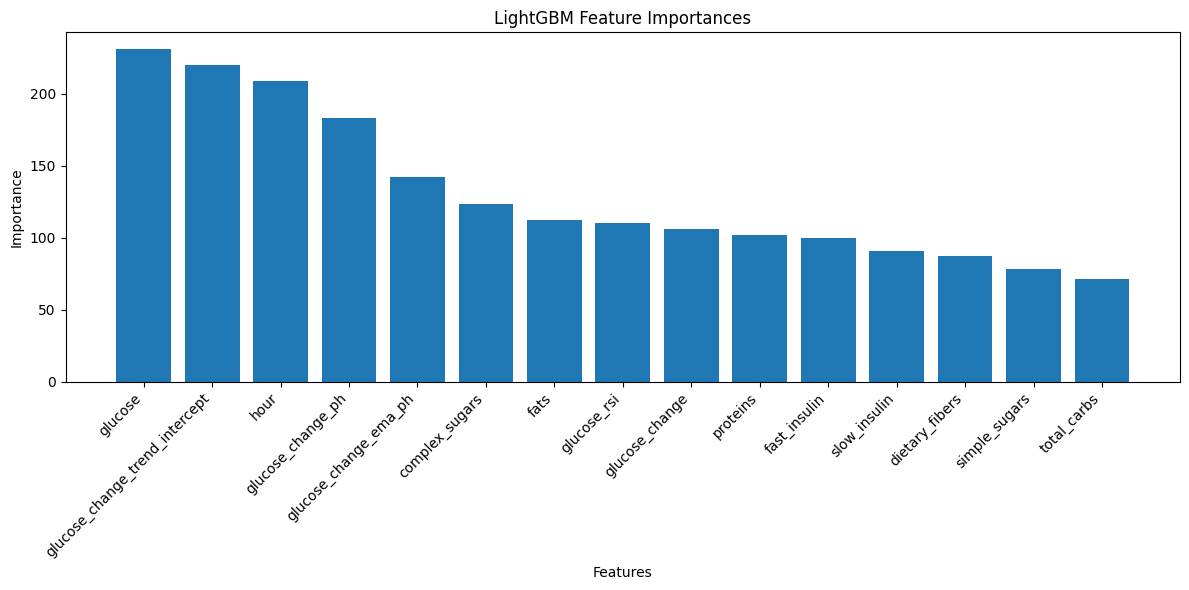

In [37]:
# Get feature importances
import matplotlib.pyplot as plt
importances = model.feature_importances_
feature_names = model.feature_name_

# Create dataframe of features and importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()